<a href="https://colab.research.google.com/github/BrajanNieto/MPPT_Algorithms/blob/main/IA_Fundamentals_Evaluation_MPPT_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IA Fundamentals - MPPT Algorithms**

---



*   This script focuses on evaluating the efficiency of Maximum Power Point Tracking (MPPT) algorithms in photovoltaic (solar) systems. It conducts a comparative analysis of three specific algorithms: Perturb and Observe (P&O), Genetic Algorithms (GA), and Artificial Neural Networks (ANN).

**Professor:**  
Mg. Machaca Vicente Arceda  
[vicente.machaca.a@gmail.com](mailto:vicente.machaca.a@gmail.com)

**Authors:**  
Nevado Talledo, Jose E.  
[jose.nevado@utec.edu.pe](mailto:jose.nevado@utec.edu.pe)

Nieto Espinoza, Brajan E.  
[brajan.nieto@utec.edu.pe](mailto:brajan.nieto@utec.edu.pe)

Peña la Torre, Walter J.
[walter.pena.l@utec.edu.pe](mailto:walter.pena.l@utec.edu.pe)

<img src="https://pregrado.utec.edu.pe/sites/default/files/logo-utec-h_0_0.svg" width="190" alt="Logo UTEC" loading="lazy" typeof="foaf:Image">

---

In [3]:
# Import standard libraries for numerical computations and data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import lambertw
import math
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor


# 01. Problem Formulation

## 01.1 Irradiance and Temperature Profile
Defines functions that models the variation of irradiance and temperature over time in a photovoltaic system. The function uses conditional statements to describe changes in irradiance based on specified time intervals.

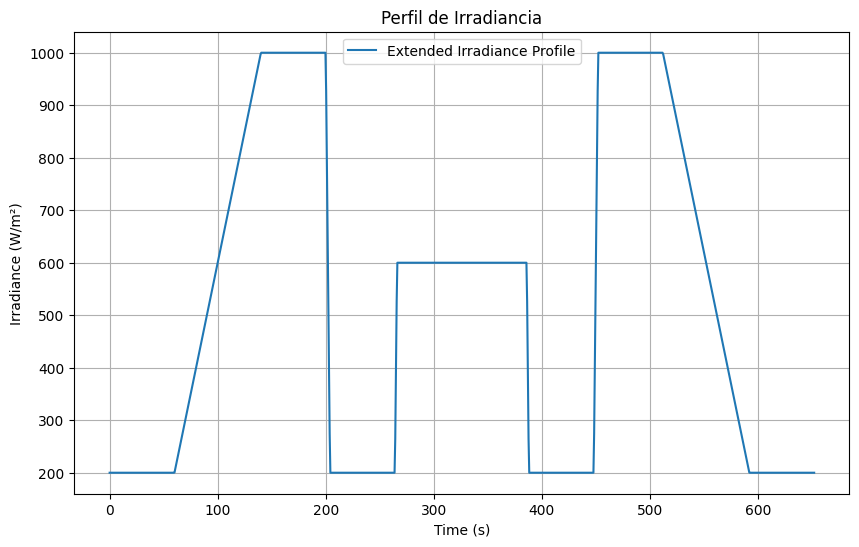

In [4]:
def irradiance_profile(time):
    """
    Defines how irradiance varies over time.
    """
    if time <= 60:
        return 200
    elif 60 < time <= 140:
        return 200 + 10 * (time - 60)
    elif 140 < time <= 200:
        return 1000
    elif 200 < time <= 204:
        return 1000 - 200 * (time - 200)
    elif 204 < time <= 264:
        return 200
    elif 264 < time <= 266:
        return 200 + 200 * (time - 264)
    elif 266 < time <= 386:
        return 600
    elif 386 < time <= 388:
        return 600 - 200 * (time - 386)
    elif 388 < time <= 448:
        return 200
    elif 448 < time <= 452:
        return 200 + 200* (time - 448)
    elif 452 < time <= 512:
        return 1000
    elif 512 < time <= 592:
        return 1000 - 10 * (time - 512)
    elif 592 < time <= 652:
        return 200
    else:
        return 200


time_extended = np.linspace(0, 652, 1000)
irradiance_extended = [irradiance_profile(t) for t in time_extended]

# Plot the extended irradiance profile
plt.figure(figsize=(10, 6))
plt.plot(time_extended, irradiance_extended, label="Extended Irradiance Profile")
plt.title("Perfil de Irradiancia")
plt.xlabel("Time (s)")
plt.ylabel("Irradiance (W/m²)")
plt.grid()
plt.legend()
plt.show()


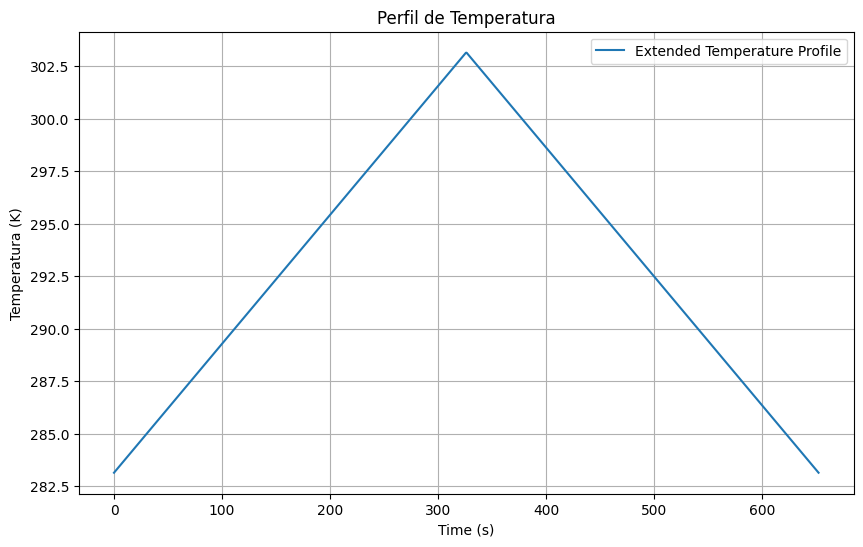

In [5]:
def temperature_profile(time):
    """
    Defines how temperature varies over time.
    """
    if time <= 326:
        # Temperatura aumenta de 25°C (298.15 K) a 35°C (308.15 K) en 326 s
        return 283.15 + (time / 326) * 20
    elif 326 < time <= 652:
        # Temperatura disminuye de 35°C (308.15 K) a 25°C (298.15 K) en 326s
        return 303.15 - ((time - 326) / 326) * 20
    else:
        return 298.15


temperature_extended = [temperature_profile(t) for t in time_extended]

# Plot the temperature profile over time.
plt.figure(figsize=(10, 6))
plt.plot(time_extended, temperature_extended, label="Extended Temperature Profile")
plt.title("Perfil de Temperatura")
plt.xlabel("Time (s)")
plt.ylabel("Temperatura (K)")
plt.grid()
plt.legend()
plt.show()


## 01.2 Fotocorriente (Iph)

Calculate_Iph function to compute the photocurrent (Iph) as a function of time, temperature, and irradiance. The calculation uses temperature and irradiance profiles, alongside key reference parameters. The script then plots the time-dependent behavior of Iph.

The equation used to calculate the photocurrent \(I_{ph}\) is:

$I_{ph} = \left(I_{sc\_ref} + \alpha_{Isc} \cdot (T - T_{ref})\right) \cdot \frac{G}{G_{ref}}$

Where:

- $I_{sc\_ref}$: Short-circuit current under standard conditions (A).
- $\alpha_{Isc}$: Temperature coefficient for $I_{sc}$ (in A/K).
- $T$: Temperature in Kelvin as a function of time.
- $T_{ref}$: Reference temperature in Kelvin.
- $G$: Solar irradiance (in W/m²) as a function of time.
- $G_{ref}$: Reference solar irradiance (in W/m²).


In [6]:
# Parámetros del panel solar
I_sc_ref = 8.5        # Corriente de cortocircuito a condiciones estándar (A)
alpha_Isc = 0.0005    # Coeficiente de temperatura de I_sc (A/K)
T_ref = 298.15        # Temperatura de referencia (25°C en Kelvin)
G_ref = 1000          # Irradiancia solar de referencia. (W/m2)

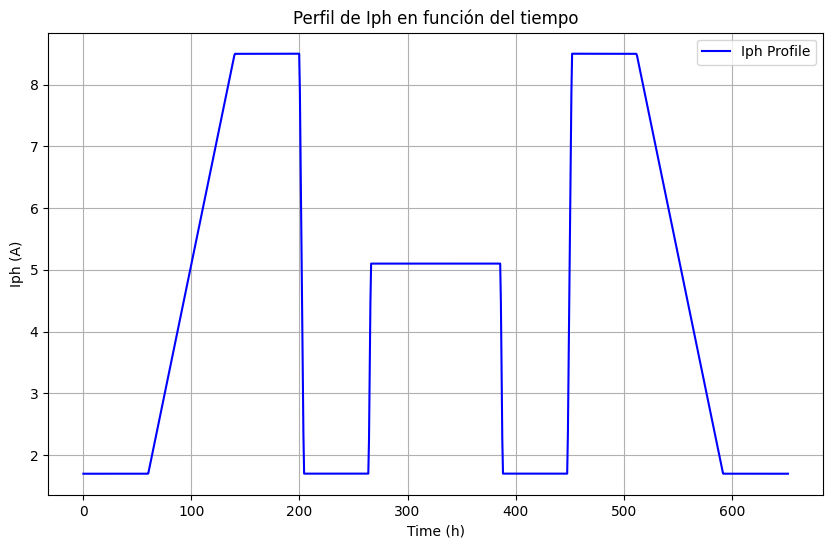

In [7]:
def calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref):
    """
    Calculates the photocurrent (Iph) as a function of time.

    Parameters:
        time (float): Time at which Iph is calculated.
        I_sc_ref (float): Short-circuit current under standard conditions (A).
        alpha_Isc (float): Temperature coefficient of Isc (A/K).
        T_ref (float): Reference temperature in Kelvin.
        G_ref (float): Reference solar irradiance (W/m^2).

    Returns:
        float: Value of Iph at the given time.
    """
    # Get temperature (T) and irradiance (G) values from their respective profiles
    T = temperature_profile(time)  # Temperature in Kelvin
    G = irradiance_profile(time)   # Irradiance in W/m^2

    # Calculate Iph using the formula:
    Iph = (I_sc_ref + alpha_Isc * (T - T_ref)) * (G / G_ref)
    return Iph


Iph_extended = [calculate_Iph(t, I_sc_ref, alpha_Isc, T_ref, G_ref) for t in time_extended]

# Plot the Iph profile
plt.figure(figsize=(10, 6))
plt.plot(time_extended, Iph_extended, label="Iph Profile", color='blue')
plt.title("Perfil de Iph en función del tiempo")
plt.xlabel("Time (h)")
plt.ylabel("Iph (A)")
plt.grid()
plt.legend()
plt.show()

## Corriente de saturación inversa del diodo ($ I_0 $)

La corriente de saturación inversa del diodo, $ I_0 $, se calcula con la siguiente fórmula:

$
I_0 = I_{sc\_ref} \cdot \left( \frac{T}{T_{ref}} \right)^3 \cdot e^{-\frac{E_g \cdot q}{k \cdot T}}
$

### Parámetros
- $ I_{sc\_ref} $: Corriente de cortocircuito bajo condiciones estándar (A).
- $T $: Temperatura en Kelvin en el tiempo actual ($ time$).
- $T_{ref} $: Temperatura de referencia en Kelvin.
- $ E_g $: Energía de la banda prohibida del material semiconductor (eV).
- $ q $: Carga del electrón ($ 1.602 \times 10^{-19} \, C $).
- $ k $: Constante de Boltzmann ($ 1.38 \times 10^{-23} \, J/K $).



In [ ]:
# Constantes físicas
k = 1.380649e-23     # Constante de Boltzmann (J/K)
q = 1.602176634e-19  # Carga del electrón (C)
# Parámetros del panel solar
V_oc_ref = 22.0       # Voltaje de circuito abierto a condiciones estándar (V)
n = 1.3               # Factor de idealidad del diodo
E_g = 1.1            # Energía de la banda prohibida (eV)
# Determinar número de celdas en serie
V_oc_cell = 0.611        # Voltaje de circuito abierto por celda (V)
N_s = int(V_oc_ref / V_oc_cell)
print(f"Número de celdas en serie: {N_s}")
# Parámetros por celda
I_sc_ref_cell = I_sc_ref  # Corriente de cortocircuito por celda (A)
V_oc_ref_cell = V_oc_ref / N_s  # Voltaje de circuito abierto por celda (V)
R_s_cell = R_s / N_s            # Resistencia serie por celda (Ω)
R_sh_cell = R_sh * N_s          # Resistencia shunt por celda (Ω)

Número de celdas en serie: 36


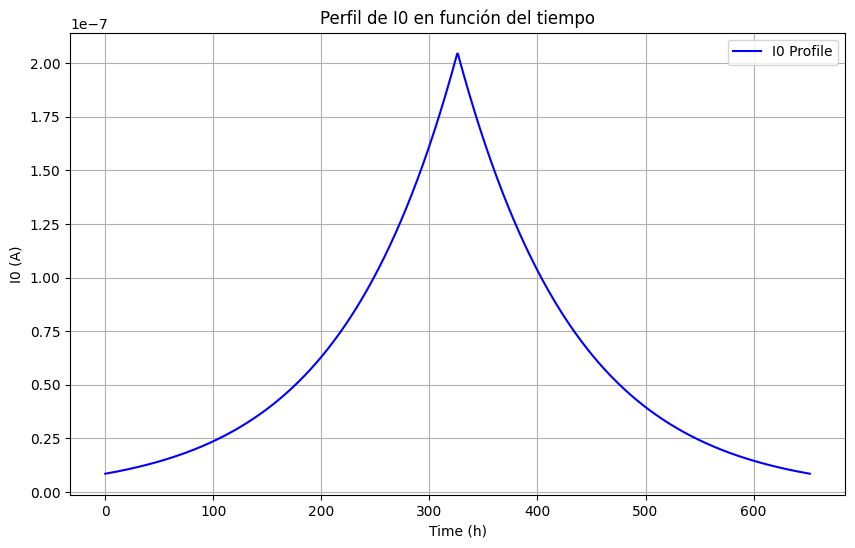

In [ ]:
def calculate_I0(time, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q):
    T = temperature_profile(time)
    E_g_J = E_g * q
    V_t_ref = k * T_ref / q
    exponent_ref = q * V_oc_ref_cell / (n * k * T_ref)
    if exponent_ref > 100:
        I0_ref = I_sc_ref_cell * math.exp(-exponent_ref)
    else:
        I0_ref = I_sc_ref_cell / (math.exp(exponent_ref) - 1)
    delta_T_inv = (1 / T) - (1 / T_ref)
    exponent = -E_g_J / k * delta_T_inv
    I0 = I0_ref * (T / T_ref)**3 * math.exp(exponent)
    return I0

# Graficar el perfil de I0
I0_extended = [calculate_I0 (t, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q) for t in time_extended]
plt.figure(figsize=(10, 6))
plt.plot(time_extended, I0_extended, label="I0 Profile", color='blue')
plt.title("Perfil de I0 en función del tiempo")
plt.xlabel("Time (h)")
plt.ylabel("I0 (A)")
plt.grid()
plt.legend()
plt.show()

### Modelo de 1 diodo

El modelo de un diodo para un panel solar se describe mediante la siguiente fórmula:

$I = I_{ph} - I_0 \cdot \left( e^{\frac{q \cdot (V + I \cdot R_s)}{n \cdot k \cdot T}} - 1 \right) - \frac{V + I \cdot R_s}{R_{sh}}$

### Donde:
- $I$: Corriente de salida del panel solar (A).
- $I_{ph}$: Fotocorriente generada por la luz incidente (A).
- $I_0$: Corriente de saturación inversa del diodo (A).
- $q$: Carga del electrón ($1.602 \times 10^{-19} \, C$).
- $V$: Voltaje en los terminales del panel solar (V).
- $R_s$: Resistencia en serie del panel solar ($\Omega$).
- $R_{sh}$: Resistencia en paralelo (o shunt) del panel solar ($\Omega$).
- $n$: Factor de idealidad del diodo (típicamente entre 1 y 2).
- $k$: Constante de Boltzmann ($1.381 \times 10^{-23} \, J/K$).
- $T$: Temperatura absoluta del panel (K).

In [ ]:
# Parámetros del panel solar (ejemplo)
R_s = 0.1             # Resistencia serie (Ω)
R_sh = 1000.0         # Resistencia paralela (Ω)

In [ ]:
def current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q):
    I_ph = calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref)
    I_0 = calculate_I0(time, I_sc_ref, V_oc_ref, n, T_ref, E_g, k, q)
    T = temperature_profile(time)
    V_t = k * T / q

    # Definir la ecuación implícita a resolver
    def diode_equation(I):
        exponent = (V + I * R_s) / (n * V_t)
        # Controlar el exponente para evitar OverflowError
        if exponent > 700:
            exp_term = np.exp(700)
        else:
            exp_term = np.exp(exponent)
        return I_ph - I_0 * (exp_term - 1) - (V + I * R_s) / R_sh - I

    # Usar fsolve para resolver la ecuación
    I_initial_guess = I_ph  # Aproximación inicial
    I_solution, info, ier, mesg = fsolve(diode_equation, I_initial_guess, full_output=True)
    if ier != 1:
        print(f"Solución no encontrada en V={V}, tiempo={time}: {mesg}")
        I_solution = [np.nan]  # Asignar NaN si no converge
    return I_solution[0]

Solución no encontrada en V=23.149549549549548, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.175975975975973, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.202402402402402, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.228828828828828, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.255255255255253, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.28168168168168, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

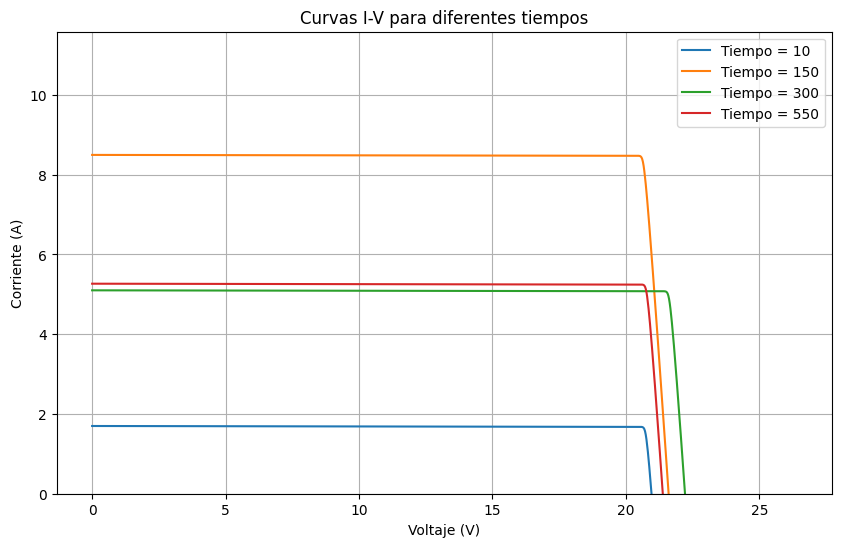

In [ ]:
# Tiempos específicos
times = [10, 150, 300, 550]  # Puedes ajustar estos valores

# Rango de voltajes
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 100 puntos entre 0 V y V_oc_ref

# Graficar las curvas I-V para cada tiempo
plt.figure(figsize=(10, 6))
for time in times:
    I_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    plt.plot(V_values, I_values, label=f'Tiempo = {time}')

# Limitar el eje Y a valores no negativos
plt.ylim(0, None)

# Personalizar etiquetas y leyenda
plt.title('Curvas I-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Corriente (A)')
plt.legend()
plt.grid(True)
plt.show()

Solución no encontrada en V=23.149549549549548, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.175975975975973, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.202402402402402, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.228828828828828, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.255255255255253, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.28168168168168, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

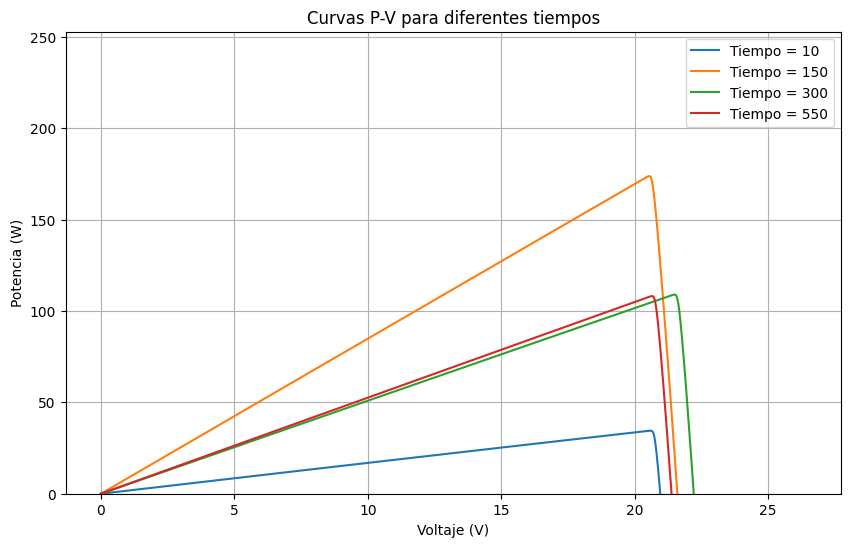

In [ ]:
# Tiempos específicos
times = [10, 150, 300, 550]  # Puedes ajustar estos valores

# Rango de voltajes
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 puntos entre 0 V y V_oc_ref

# Graficar las curvas P-V para cada tiempo
plt.figure(figsize=(10, 6))
for time in times:
    P_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I  # Potencia
        P_values.append(P)
    plt.plot(V_values, P_values, label=f'Tiempo = {time}')

# Limitar el eje Y a valores no negativos
plt.ylim(0, None)

# Personalizar etiquetas y leyenda
plt.title('Curvas P-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Potencia (W)')
plt.legend()
plt.grid(True)
plt.show()

Solución no encontrada en V=23.149549549549548, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.175975975975973, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.202402402402402, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.228828828828828, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.255255255255253, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.28168168168168, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

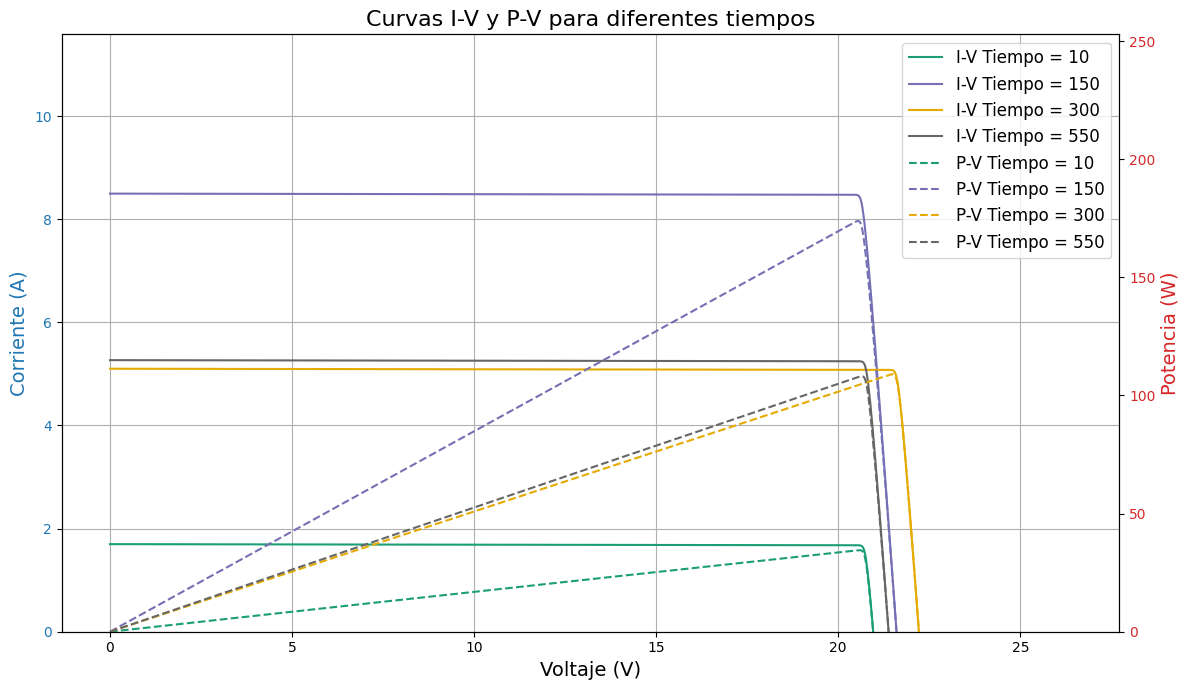

In [ ]:

# Tiempos específicos
times = [10, 150, 300, 550]  # Puedes ajustar estos valores

# Rango de voltajes
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 puntos entre 0 V y 1.2 * V_oc_ref

# Crear la figura y el eje principal
fig, ax1 = plt.subplots(figsize=(12, 7))

# Colores para diferentes tiempos
colors = plt.cm.Dark2(np.linspace(0, 1, len(times)))

# Graficar las curvas I-V para cada tiempo en el eje principal
for idx, time in enumerate(times):
    I_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    ax1.plot(V_values, I_values, label=f'I-V Tiempo = {time}', color=colors[idx], linestyle='-')

# Configurar el eje Y principal (Corriente)
ax1.set_xlabel('Voltaje (V)', fontsize=14)
ax1.set_ylabel('Corriente (A)', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, None)  # Limitar a valores no negativos

# Crear el eje secundario para la Potencia
ax2 = ax1.twinx()

# Graficar las curvas P-V para cada tiempo en el eje secundario
for idx, time in enumerate(times):
    P_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I  # Potencia
        P_values.append(P)
    ax2.plot(V_values, P_values, label=f'P-V Tiempo = {time}', color=colors[idx], linestyle='--')

# Configurar el eje Y secundario (Potencia)
ax2.set_ylabel('Potencia (W)', fontsize=14, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, None)  # Limitar a valores no negativos

# Título y leyendas
plt.title('Curvas I-V y P-V para diferentes tiempos', fontsize=16)

# Manejar las leyendas para ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

# Añadir una cuadrícula
ax1.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [ ]:
# Rango de tiempo (segundos)
time_start = 1
time_end = 652
time_steps = np.arange(time_start, time_end + 1)  # Incluye el tiempo_end

Procesando tiempos:   2%|▏         | 12/652 [00:00<00:18, 34.48it/s]

Solución no encontrada en V=26.4, tiempo=3: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=5: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=9: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=11: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=12: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   3%|▎         | 20/652 [00:00<00:18, 34.09it/s]

Solución no encontrada en V=26.4, tiempo=13: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=16: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=17: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=18: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=21: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   4%|▍         | 28/652 [00:00<00:18, 33.98it/s]

Solución no encontrada en V=26.4, tiempo=23: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  32%|███▏      | 206/652 [00:08<00:14, 31.84it/s]

Solución no encontrada en V=22.933333333333334, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.2, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  34%|███▎      | 219/652 [00:08<00:12, 34.51it/s]

Solución no encontrada en V=24.53333333333333, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.333333333333332, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.6, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  35%|███▍      | 227/652 [00:08<00:12, 33.35it/s]

Solución no encontrada en V=23.2, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  36%|███▌      | 235/652 [00:09<00:12, 34.00it/s]

Solución no encontrada en V=23.2, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  37%|███▋      | 243/652 [00:09<00:12, 32.83it/s]

Solución no encontrada en V=23.2, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  38%|███▊      | 247/652 [00:09<00:12, 31.84it/s]

Solución no encontrada en V=23.466666666666665, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  40%|███▉      | 259/652 [00:09<00:11, 33.38it/s]

Solución no encontrada en V=23.466666666666665, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  41%|████      | 267/652 [00:10<00:11, 34.16it/s]

Solución no encontrada en V=25.333333333333332, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.6, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.133333333333333, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  43%|████▎     | 279/652 [00:10<00:11, 32.88it/s]

Solución no encontrada en V=23.2, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  44%|████▍     | 287/652 [00:10<00:11, 31.12it/s]

Solución no encontrada en V=23.2, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  45%|████▌     | 295/652 [00:11<00:11, 31.84it/s]

Solución no encontrada en V=26.4, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.2, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.533333333

Procesando tiempos:  46%|████▋     | 303/652 [00:11<00:10, 32.63it/s]

Solución no encontrada en V=24.0, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.333333333333332, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  48%|████▊     | 311/652 [00:11<00:10, 32.09it/s]

Solución no encontrada en V=23.2, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  49%|████▉     | 319/652 [00:11<00:10, 32.23it/s]

Solución no encontrada en V=23.2, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  50%|█████     | 327/652 [00:12<00:10, 32.49it/s]

Solución no encontrada en V=23.466666666666665, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  51%|█████▏    | 335/652 [00:12<00:09, 33.65it/s]

Solución no encontrada en V=23.466666666666665, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  53%|█████▎    | 343/652 [00:12<00:09, 32.50it/s]

Solución no encontrada en V=23.466666666666665, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  55%|█████▍    | 356/652 [00:12<00:08, 33.63it/s]

Solución no encontrada en V=25.6, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.133333333333333, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.2, tiempo=347: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=347: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333

Procesando tiempos:  55%|█████▌    | 360/652 [00:13<00:08, 32.60it/s]

Solución no encontrada en V=23.2, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  56%|█████▋    | 368/652 [00:13<00:09, 30.94it/s]

Solución no encontrada en V=23.733333333333334, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  58%|█████▊    | 376/652 [00:13<00:09, 29.78it/s]

Solución no encontrada en V=23.2, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  59%|█████▉    | 384/652 [00:13<00:08, 30.51it/s]

Solución no encontrada en V=23.2, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  60%|██████    | 392/652 [00:14<00:08, 31.99it/s]

Solución no encontrada en V=23.2, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  61%|██████▏   | 400/652 [00:14<00:07, 31.98it/s]

Solución no encontrada en V=23.466666666666665, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  62%|██████▏   | 404/652 [00:14<00:08, 30.48it/s]

Solución no encontrada en V=23.466666666666665, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  63%|██████▎   | 408/652 [00:14<00:09, 27.00it/s]

Solución no encontrada en V=23.466666666666665, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  63%|██████▎   | 414/652 [00:15<00:09, 24.76it/s]

Solución no encontrada en V=23.2, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  64%|██████▍   | 420/652 [00:15<00:09, 24.14it/s]

Solución no encontrada en V=23.2, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  65%|██████▍   | 423/652 [00:15<00:10, 22.44it/s]

Solución no encontrada en V=23.2, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  66%|██████▌   | 429/652 [00:15<00:10, 21.74it/s]


Solución no encontrada en V=24.53333333333333, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.333333333333332, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.6, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  66%|██████▋   | 432/652 [00:15<00:10, 21.51it/s]

Solución no encontrada en V=23.2, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  67%|██████▋   | 438/652 [00:16<00:09, 23.35it/s]

Solución no encontrada en V=23.2, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  68%|██████▊   | 444/652 [00:16<00:08, 23.28it/s]


Solución no encontrada en V=23.466666666666665, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  69%|██████▊   | 447/652 [00:16<00:08, 24.00it/s]

Solución no encontrada en V=23.2, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  98%|█████████▊| 636/652 [00:23<00:00, 33.77it/s]

Solución no encontrada en V=26.4, tiempo=629: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=631: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=634: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=635: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=636: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  99%|█████████▉| 648/652 [00:23<00:00, 31.97it/s]

Solución no encontrada en V=26.4, tiempo=639: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=640: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=641: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=643: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=647: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos: 100%|██████████| 652/652 [00:23<00:00, 27.55it/s]


Solución no encontrada en V=26.4, tiempo=652: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
   Tiempo (s)   Pmax (W)
0           1  34.419236
1           2  34.423234
2           3  34.426758
3           4  34.429868
4           5  34.432614


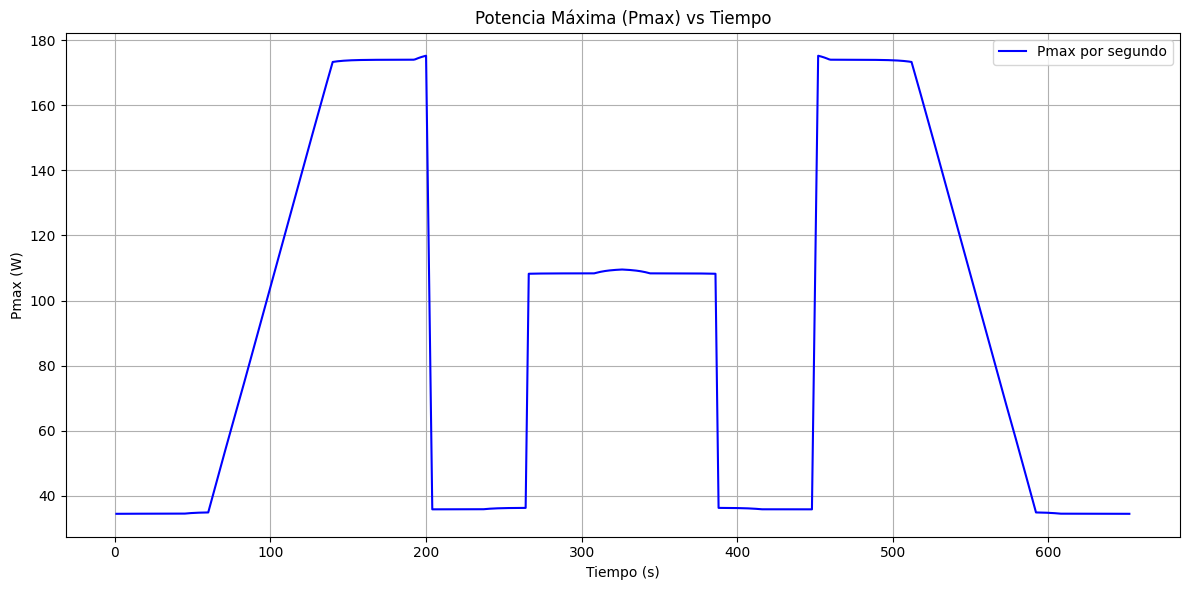

In [ ]:
# Lista para almacenar Pmax y tiempos correspondientes
pmax_list = []
time_list = []

# Voltaje máximo para cada tiempo
V_max_multiplier = 1.2  # Multiplicador para V_oc_ref

# Número de puntos de voltaje (puedes ajustarlo según la precisión requerida)
V_points = 100

# Iterar sobre cada segundo
for current_time in tqdm(time_steps, desc="Procesando tiempos"):
    # Definir rango de voltaje para este tiempo
    V_oc_current = V_oc_ref  # Asumiendo que V_oc_ref es constante; ajusta si es variable
    V_max = V_max_multiplier * V_oc_current
    V_range = np.linspace(0, V_max, V_points)

    # Listas para almacenar V, I y P para este tiempo
    I_values = []
    P_values = []

    # Iterar sobre cada voltaje
    for V in V_range:
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
        if np.isnan(I):
            P = 0  # Asignar 0 potencia si la corriente no se encontró
        else:
            P = V * I
        I_values.append(I)
        P_values.append(P)

    # Encontrar Pmax y el índice correspondiente
    P_values = np.array(P_values)
    if np.all(np.isnan(P_values)):
        P_max = np.nan
    else:
        P_max = np.nanmax(P_values)  # Usa np.nanmax para ignorar NaNs

    # Almacenar los resultados
    pmax_list.append(P_max)
    time_list.append(current_time)

# Crear un DataFrame con los resultados
df_pmax = pd.DataFrame({
    'Tiempo (s)': time_list,
    'Pmax (W)': pmax_list
})

# Mostrar las primeras filas del DataFrame
print(df_pmax.head())

# Guardar los resultados en un archivo CSV (opcional)
# df_pmax.to_csv('pmax_vs_time.csv', index=False)

# Graficar Pmax vs Tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_pmax['Tiempo (s)'], df_pmax['Pmax (W)'], color='blue', label='Pmax por segundo')
plt.title('Potencia Máxima (Pmax) vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Pmax (W)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

     Tiempo (s)   Pmax (W)  Irradiancia  Relación Irradiancia/Pmax
0             1  34.419236          200                   5.810704
1             2  34.423234          200                   5.810029
2             3  34.426758          200                   5.809435
3             4  34.429868          200                   5.808910
4             5  34.432614          200                   5.808447
..          ...        ...          ...                        ...
647         648  34.429868          200                   5.808910
648         649  34.426758          200                   5.809435
649         650  34.423234          200                   5.810029
650         651  34.419236          200                   5.810704
651         652  34.414701          200                   5.811470

[652 rows x 4 columns]


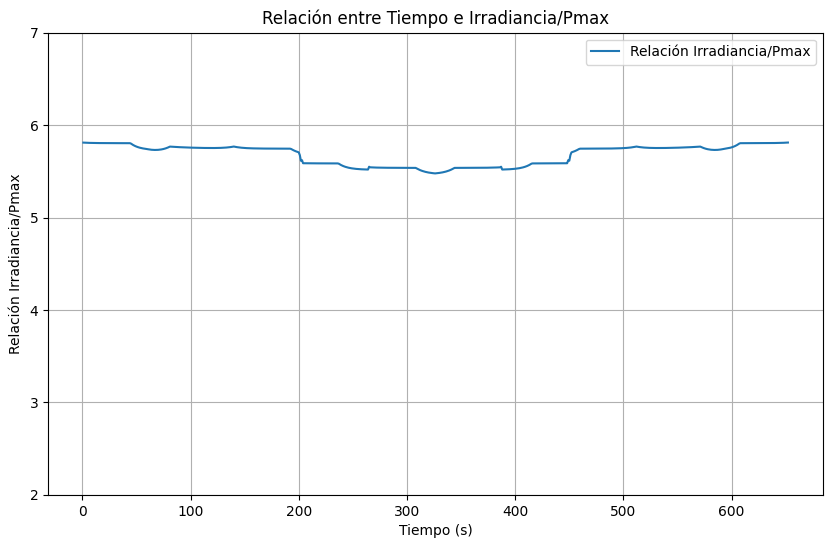

In [ ]:
# Añadir columna de Irradiancia usando la función
df_pmax['Irradiancia'] = df_pmax['Tiempo (s)'].apply(irradiance_profile)

# Añadir columna de relación entre Irradiancia y Pmax
df_pmax['Relación Irradiancia/Pmax'] = df_pmax['Irradiancia'] / df_pmax['Pmax (W)']

# Mostrar el DataFrame resultante
print(df_pmax)
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(df_pmax['Tiempo (s)'], df_pmax['Relación Irradiancia/Pmax'], linestyle='-', label='Relación Irradiancia/Pmax')
plt.title('Relación entre Tiempo e Irradiancia/Pmax')
plt.xlabel('Tiempo (s)')
plt.ylabel('Relación Irradiancia/Pmax')
plt.ylim(2, 7)  # Escalar el eje Y entre 2 y 7
plt.grid()
plt.legend()
plt.show()

# Implementación de algoritmos

In [ ]:
def incremental_conductance(V_prev, I_prev, dV, dI):
    """
    Implementa el algoritmo de conductancia incremental.

    Parámetros:
        V_prev (float): Voltaje en el paso anterior.
        I_prev (float): Corriente en el paso anterior.
        dV (float): Cambio en el voltaje (V_actual - V_anterior).
        dI (float): Cambio en la corriente (I_actual - I_anterior).

    Retorna:
        V_next (float): Nuevo voltaje ajustado.
    """
    if dV == 0:
        return V_prev  # Evita división por cero

    G_inc = dI / dV  # Conductancia incremental
    G_inst = I_prev / V_prev  # Conductancia instantánea

    if abs(G_inc + G_inst) < 1e-6:
        # Máxima potencia alcanzada
        V_next = V_prev
    elif G_inc + G_inst > 0:
        # Incrementar voltaje
        V_next = V_prev + delta_V
    else:
        # Disminuir voltaje
        V_next = V_prev - delta_V
    return V_next

In [ ]:
def perturb_and_observe(V_prev, P_prev, delta_V, direction):
    """
    Implementa el algoritmo de perturbar y observar.

    Parámetros:
        V_prev (float): Voltaje en el paso anterior.
        P_prev (float): Potencia en el paso anterior.
        delta_V (float): Paso de perturbación en voltaje.
        direction (int): Dirección actual (1 para aumentar, -1 para disminuir).

    Retorna:
        V_next (float): Nuevo voltaje ajustado.
        direction (int): Nueva dirección ajustada.
    """
    V_next = V_prev + direction * delta_V
    return V_next, direction


In [ ]:
def genetic_algorithm(time, V_min, V_max, population_size, generations):
    """
    Implementa una versión simplificada de un algoritmo genético para encontrar el voltaje óptimo.

    Parámetros:
        time (float): Tiempo actual.
        V_min (float): Voltaje mínimo posible.
        V_max (float): Voltaje máximo posible.
        population_size (int): Tamaño de la población.
        generations (int): Número de generaciones.

    Retorna:
        V_best (float): Voltaje óptimo encontrado.
    """
    # Generar población inicial
    population = np.random.uniform(V_min, V_max, population_size)

    for _ in range(generations):
        # Evaluar la aptitud (fitness)
        fitness = []
        for V in population:
            I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
            P = V * I if not np.isnan(I) else 0
            fitness.append(P)
        fitness = np.array(fitness)

        # Seleccionar los mejores individuos
        indices = np.argsort(fitness)[-population_size//2:]  # Selecciona la mitad superior
        population = population[indices]

        # Cruce y mutación
        children = []
        while len(children) < population_size:
            parents = np.random.choice(population, 2)
            child = np.mean(parents)
            # Mutación
            child += np.random.normal(0, (V_max - V_min) * 0.01)
            child = np.clip(child, V_min, V_max)
            children.append(child)
        population = np.array(children)

    # Mejor solución
    best_index = np.argmax(fitness)
    V_best = population[best_index]
    return V_best

In [ ]:
# Entrenamiento de la red neuronal (debe hacerse antes del bucle principal)
def train_neural_network(times, V_oc_ref):
    """
    Entrena una red neuronal para predecir el voltaje óptimo.

    Parámetros:
        times (array): Array de tiempos para el entrenamiento.
        V_oc_ref (float): Tensión de circuito abierto de referencia.

    Retorna:
        model: Modelo entrenado de MLPRegressor.
    """
    # Datos de entrenamiento (usando el voltaje en el que se alcanzó Pmax)
    V_optimal = []
    for time in times:
        V_values = np.linspace(0, V_oc_ref * 1.2, 100)
        P_values = []
        for V in V_values:
            I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref,
                                     G_ref, E_g, R_s, R_sh, k, q)
            if np.isnan(I):
                P = 0
            else:
                P = V * I
            P_values.append(P)
        P_values = np.array(P_values)
        idx_max = np.argmax(P_values)
        V_optimal.append(V_values[idx_max])

    X_train = np.array(times).reshape(-1, 1)
    y_train = np.array(V_optimal)

    # Crear y entrenar el modelo
    model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000)
    model.fit(X_train, y_train)
    return model


Se han truncado las últimas 5000 líneas del flujo de salida.
Solución no encontrada en V=23.466666666666665, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=252: The iteration is not making good progress, as measured by the 
  improvem

Procesando tiempos:   1%|          | 6/652 [00:00<00:28, 22.33it/s]

Solución no encontrada en V=26.4, tiempo=3: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=5: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   2%|▏         | 15/652 [00:00<00:31, 20.25it/s]

Solución no encontrada en V=26.4, tiempo=9: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=11: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=12: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=13: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   3%|▎         | 21/652 [00:01<00:31, 19.94it/s]

Solución no encontrada en V=26.4, tiempo=16: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=17: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=18: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=21: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   4%|▍         | 26/652 [00:01<00:31, 19.70it/s]

Solución no encontrada en V=26.4, tiempo=23: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  31%|███▏      | 205/652 [00:11<00:29, 14.94it/s]

Solución no encontrada en V=22.8969696969697, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solu

Procesando tiempos:  32%|███▏      | 210/652 [00:11<00:25, 17.30it/s]

Solución no encontrada en V=23.1030303030303, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=208: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  33%|███▎      | 215/652 [00:12<00:23, 18.48it/s]

Solución no encontrada en V=23.1030303030303, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=213: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  34%|███▎      | 219/652 [00:12<00:22, 19.00it/s]

Solución no encontrada en V=23.515151515151516, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=217: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  35%|███▍      | 225/652 [00:12<00:21, 20.20it/s]

Solución no encontrada en V=24.545454545454547, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.369696969696967, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=222: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

Procesando tiempos:  35%|███▌      | 230/652 [00:12<00:22, 19.17it/s]

Solución no encontrada en V=24.545454545454547, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.369696969696967, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=227: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

Procesando tiempos:  36%|███▌      | 236/652 [00:13<00:20, 19.89it/s]

Solución no encontrada en V=25.369696969696967, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.78181818181818, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.98787878787879, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=232: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no en

Procesando tiempos:  37%|███▋      | 240/652 [00:13<00:21, 19.05it/s]

Solución no encontrada en V=23.30909090909091, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=237: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  37%|███▋      | 244/652 [00:13<00:21, 18.73it/s]

Solución no encontrada en V=23.30909090909091, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=242: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  38%|███▊      | 251/652 [00:13<00:21, 19.00it/s]

Solución no encontrada en V=26.4, tiempo=247: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.719978465688655, tiempo=247: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=248: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no en

Procesando tiempos:  39%|███▉      | 256/652 [00:14<00:20, 19.39it/s]

Solución no encontrada en V=23.30909090909091, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  40%|███▉      | 258/652 [00:14<00:20, 19.18it/s]

Solución no encontrada en V=23.30909090909091, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=257: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  41%|████      | 266/652 [00:14<00:19, 20.16it/s]

Solución no encontrada en V=23.30909090909091, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  42%|████▏     | 271/652 [00:15<00:19, 19.22it/s]


Solución no encontrada en V=23.30909090909091, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=267: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  42%|████▏     | 276/652 [00:15<00:21, 17.62it/s]

Solución no encontrada en V=23.927272727272726, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=274: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  43%|████▎     | 280/652 [00:15<00:20, 18.06it/s]

Solución no encontrada en V=23.1030303030303, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=277: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  43%|████▎     | 282/652 [00:15<00:20, 17.97it/s]

Solución no encontrada en V=24.33939393939394, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.369696969696967, tiempo=281: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  44%|████▍     | 287/652 [00:15<00:19, 19.07it/s]

Solución no encontrada en V=23.1030303030303, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=286: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  45%|████▍     | 293/652 [00:16<00:19, 18.77it/s]

Solución no encontrada en V=25.191711471857353, tiempo=289: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  46%|████▌     | 298/652 [00:16<00:19, 18.47it/s]

Solución no encontrada en V=23.30909090909091, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=294: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  46%|████▋     | 302/652 [00:16<00:18, 18.65it/s]

Solución no encontrada en V=23.515151515151516, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  47%|████▋     | 308/652 [00:17<00:18, 18.67it/s]

Solución no encontrada en V=23.30909090909091, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=304: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  48%|████▊     | 312/652 [00:17<00:18, 18.49it/s]

Solución no encontrada en V=23.30909090909091, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=309: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  48%|████▊     | 314/652 [00:17<00:18, 18.11it/s]

Solución no encontrada en V=25.369696969696967, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.575757575757574, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.78181818181818, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.98787878787879, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no en

Procesando tiempos:  49%|████▉     | 320/652 [00:17<00:17, 18.95it/s]

Solución no encontrada en V=23.30909090909091, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=318: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  50%|████▉     | 324/652 [00:17<00:17, 18.59it/s]

Solución no encontrada en V=24.133333333333333, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=321: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  50%|█████     | 328/652 [00:18<00:18, 17.55it/s]

Solución no encontrada en V=24.400123016802674, tiempo=325: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.115543486364704, tiempo=325: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=326: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  51%|█████     | 332/652 [00:18<00:18, 17.23it/s]

Solución no encontrada en V=23.30909090909091, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=330: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  52%|█████▏    | 336/652 [00:18<00:17, 18.14it/s]

Solución no encontrada en V=23.30909090909091, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=334: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  52%|█████▏    | 342/652 [00:18<00:16, 18.85it/s]

Solución no encontrada en V=23.30909090909091, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=339: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  53%|█████▎    | 347/652 [00:19<00:16, 18.40it/s]

Solución no encontrada en V=23.86454951842364, tiempo=343: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.517701407445614, tiempo=343: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=344: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  54%|█████▍    | 353/652 [00:19<00:16, 18.52it/s]

Solución no encontrada en V=23.30909090909091, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=350: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  55%|█████▍    | 358/652 [00:19<00:14, 20.14it/s]


Solución no encontrada en V=23.30909090909091, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=356: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  55%|█████▌    | 361/652 [00:19<00:15, 18.95it/s]

Solución no encontrada en V=23.1030303030303, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=361: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  56%|█████▋    | 368/652 [00:20<00:15, 18.34it/s]

Solución no encontrada en V=23.1030303030303, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=365: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  58%|█████▊    | 375/652 [00:20<00:14, 19.67it/s]

Solución no encontrada en V=23.1030303030303, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=370: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  58%|█████▊    | 379/652 [00:20<00:14, 19.02it/s]

Solución no encontrada en V=23.1030303030303, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=376: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  59%|█████▊    | 383/652 [00:21<00:14, 19.01it/s]

Solución no encontrada en V=25.98787878787879, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.93717223697796, tiempo=380: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=381: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=381: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encon

Procesando tiempos:  59%|█████▉    | 387/652 [00:21<00:14, 18.09it/s]

Solución no encontrada en V=25.78181818181818, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.98787878787879, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.193939393939395, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.04989168593195, tiempo=384: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.1030303030303, tiempo=385: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encon

Procesando tiempos:  60%|█████▉    | 391/652 [00:21<00:15, 17.12it/s]


Solución no encontrada en V=23.30909090909091, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=389: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  60%|██████    | 393/652 [00:21<00:16, 16.15it/s]

Solución no encontrada en V=23.30909090909091, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=392: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  61%|██████    | 395/652 [00:21<00:16, 15.40it/s]

Solución no encontrada en V=23.30909090909091, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=395: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  61%|██████    | 399/652 [00:22<00:18, 13.93it/s]

Solución no encontrada en V=23.30909090909091, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=398: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  62%|██████▏   | 403/652 [00:22<00:17, 14.07it/s]

Solución no encontrada en V=23.30909090909091, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  62%|██████▏   | 405/652 [00:22<00:17, 14.19it/s]

Solución no encontrada en V=23.30909090909091, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=404: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  63%|██████▎   | 409/652 [00:22<00:16, 14.41it/s]

Solución no encontrada en V=24.133333333333333, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.75151515151515, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.957575757575757, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.163636363636364, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  63%|██████▎   | 411/652 [00:22<00:16, 14.31it/s]

Solución no encontrada en V=23.30909090909091, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=410: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  64%|██████▎   | 415/652 [00:23<00:16, 14.45it/s]

Solución no encontrada en V=23.30909090909091, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=413: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  64%|██████▍   | 417/652 [00:23<00:17, 13.72it/s]

Solución no encontrada en V=23.30909090909091, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  65%|██████▍   | 421/652 [00:23<00:16, 14.33it/s]

Solución no encontrada en V=23.30909090909091, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=419: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  65%|██████▍   | 423/652 [00:23<00:15, 14.43it/s]

Solución no encontrada en V=23.30909090909091, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=422: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  65%|██████▌   | 427/652 [00:24<00:16, 14.05it/s]


Solución no encontrada en V=23.515151515151516, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.545454545454547, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

Procesando tiempos:  66%|██████▌   | 429/652 [00:24<00:16, 13.83it/s]

Solución no encontrada en V=23.30909090909091, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.33939393939394, tiempo=428: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
S

Procesando tiempos:  66%|██████▋   | 433/652 [00:24<00:16, 13.29it/s]

Solución no encontrada en V=23.1030303030303, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=431: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  67%|██████▋   | 435/652 [00:24<00:16, 12.96it/s]

Solución no encontrada en V=23.1030303030303, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=434: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  67%|██████▋   | 439/652 [00:25<00:16, 12.91it/s]

Solución no encontrada en V=23.1030303030303, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=437: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  68%|██████▊   | 441/652 [00:25<00:16, 12.87it/s]

Solución no encontrada en V=23.1030303030303, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  68%|██████▊   | 445/652 [00:25<00:16, 12.92it/s]

Solución no encontrada en V=23.1030303030303, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=443: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  69%|██████▉   | 450/652 [00:25<00:12, 16.39it/s]

Solución no encontrada en V=23.1030303030303, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.30909090909091, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.515151515151516, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.72121212121212, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.927272727272726, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.133333333333333, tiempo=446: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
So

Procesando tiempos:  97%|█████████▋| 634/652 [00:35<00:00, 19.00it/s]

Solución no encontrada en V=26.4, tiempo=629: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=631: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=634: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  98%|█████████▊| 636/652 [00:35<00:00, 16.63it/s]

Solución no encontrada en V=26.4, tiempo=635: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=636: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  98%|█████████▊| 640/652 [00:36<00:00, 14.09it/s]

Solución no encontrada en V=26.4, tiempo=639: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=640: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=641: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  99%|█████████▉| 644/652 [00:36<00:00, 13.92it/s]

Solución no encontrada en V=26.4, tiempo=643: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  99%|█████████▉| 648/652 [00:36<00:00, 13.73it/s]

Solución no encontrada en V=26.4, tiempo=647: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos: 100%|██████████| 652/652 [00:36<00:00, 17.62it/s]


Solución no encontrada en V=26.4, tiempo=652: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
   Tiempo       Pmax       P_IC       P_PO       P_GA       P_NN  \
0       1  34.269107  10.170945  10.170885  31.246131  20.908808   
1       2  34.269356  10.187845  10.187785  30.684037  21.717311   
2       3  34.269590  10.204745  10.204685  29.468391  22.414644   
3       4  34.269811  10.221645  10.221584  25.185111  23.102175   
4       5  34.270021  10.238545  10.238484  30.205023  23.789373   

   Eficiencia_IC  Eficiencia_PO  Eficiencia_GA  Eficiencia_NN  
0       0.296796       0.296795       0.911787       0.610136  
1       0.297287       0.297286       0.895378       0.633724  
2       0.297778       0.297777       0.859899       0.654068  
3       0.298270       0.298268       0.734907       0.674126  
4       0.298761       0.298759       0.881383       0.694174  


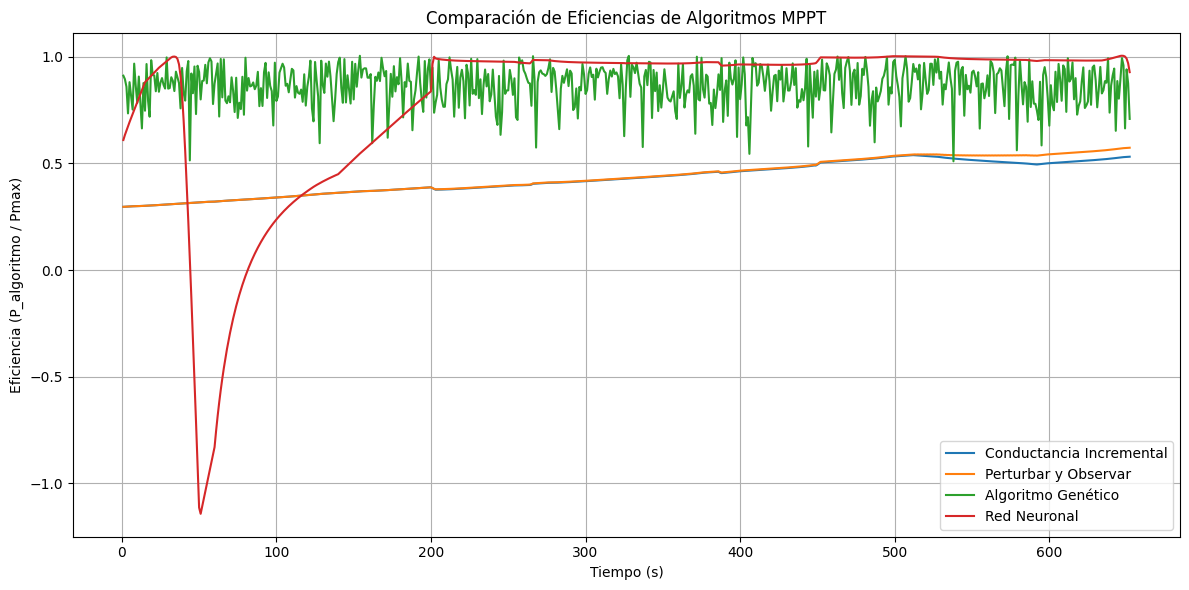

In [ ]:
# Parámetros adicionales para los algoritmos
delta_V = 0.01  # Paso de voltaje para P&O e IC
population_size = 10  # Para el algoritmo genético
generations = 5       # Para el algoritmo genético
V_min = 6
V_max = V_oc_ref * 1.2

# Entrenar la red neuronal antes del bucle principal
time_steps = np.arange(time_start, time_end + 1)
model_nn = train_neural_network(time_steps, V_oc_ref)

# Variables para almacenar los resultados
results = {
    'Tiempo': [],
    'Pmax': [],
    'P_IC': [],
    'P_PO': [],
    'P_GA': [],
    'P_NN': [],
    'Eficiencia_IC': [],
    'Eficiencia_PO': [],
    'Eficiencia_GA': [],
    'Eficiencia_NN': []
}

# Inicialización de variables para P&O e IC
V_prev_IC = V_min
V_prev_PO = V_min
I_prev_IC = current_single_diode(V_prev_IC, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
I_prev_PO = current_single_diode(V_prev_PO, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
P_prev_PO = V_prev_PO * I_prev_PO
direction_PO = 1  # Dirección inicial para P&O

# Bucle principal
for current_time in tqdm(time_steps, desc="Procesando tiempos"):
    # Actualizar V_max si V_oc cambia con el tiempo
    V_max_current = V_max  # Puedes ajustar esto si V_oc varía con el tiempo

    # Calcular Pmax real
    V_values = np.linspace(V_min, V_max_current, 100)
    P_values = []
    for V in V_values:
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
        P = V * I if not np.isnan(I) else 0
        P_values.append(P)
    P_values = np.array(P_values)
    idx_max = np.argmax(P_values)
    P_max = P_values[idx_max]
    V_max_power = V_values[idx_max]

    # Conductancia Incremental
    I_current_IC = current_single_diode(V_prev_IC, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    dV_IC = delta_V
    dI_IC = I_current_IC - I_prev_IC
    V_next_IC = incremental_conductance(V_prev_IC, I_current_IC, dV_IC, dI_IC)
    I_prev_IC = I_current_IC
    V_prev_IC = V_next_IC
    P_IC = V_next_IC * I_current_IC

    # Perturbar y Observar
    V_next_PO, direction_PO = perturb_and_observe(V_prev_PO, P_prev_PO, delta_V, direction_PO)
    I_current_PO = current_single_diode(V_next_PO, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    P_current_PO = V_next_PO * I_current_PO
    if P_current_PO > P_prev_PO:
        # Continuar en la misma dirección
        pass
    else:
        # Cambiar de dirección
        direction_PO *= -1
    V_prev_PO = V_next_PO
    P_prev_PO = P_current_PO
    P_PO = P_current_PO

    # Algoritmo Genético
    V_GA = genetic_algorithm(current_time, V_min, V_max_current, population_size, generations)
    I_GA = current_single_diode(V_GA, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    P_GA = V_GA * I_GA if not np.isnan(I_GA) else 0

    # Red Neuronal
    V_NN = model_nn.predict([[current_time]])[0]
    I_NN = current_single_diode(V_NN, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
    P_NN = V_NN * I_NN if not np.isnan(I_NN) else 0

    # Almacenar resultados
    results['Tiempo'].append(current_time)
    results['Pmax'].append(P_max)
    results['P_IC'].append(P_IC)
    results['P_PO'].append(P_PO)
    results['P_GA'].append(P_GA)
    results['P_NN'].append(P_NN)
    results['Eficiencia_IC'].append(P_IC / P_max if P_max != 0 else 0)
    results['Eficiencia_PO'].append(P_PO / P_max if P_max != 0 else 0)
    results['Eficiencia_GA'].append(P_GA / P_max if P_max != 0 else 0)
    results['Eficiencia_NN'].append(P_NN / P_max if P_max != 0 else 0)

# Crear DataFrame con los resultados
df_results = pd.DataFrame(results)

# Mostrar los primeros resultados
print(df_results.head())

# Graficar las eficiencias
plt.figure(figsize=(12, 6))
plt.plot(df_results['Tiempo'], df_results['Eficiencia_IC'], label='Conductancia Incremental')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_PO'], label='Perturbar y Observar')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_GA'], label='Algoritmo Genético')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_NN'], label='Red Neuronal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Eficiencia (P_algoritmo / Pmax)')
plt.title('Comparación de Eficiencias de Algoritmos MPPT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
